In [1]:
import os
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
from PIL import Image
import cv2

# Set up the paths
mesh_dir = "/home/runyi_yang/Gen3D/HunyuanWorld-enhance/examples/indoor_kitchen/with_mid_prompt"
mesh_files = ["mesh_layer0.ply", "mesh_layer1.ply"]

print(f"Working with meshes from: {mesh_dir}")
print(f"Available mesh files: {mesh_files}")

# Check if files exist
for mesh_file in mesh_files:
    path = os.path.join(mesh_dir, mesh_file)
    if os.path.exists(path):
        print(f"✓ {mesh_file} exists")
    else:
        print(f"✗ {mesh_file} not found")


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Working with meshes from: /home/runyi_yang/Gen3D/HunyuanWorld-enhance/examples/indoor_kitchen/with_mid_prompt
Available mesh files: ['mesh_layer0.ply', 'mesh_layer1.ply']
✓ mesh_layer0.ply exists
✓ mesh_layer1.ply exists


In [2]:
# Load the mesh files
meshes = []
mesh_info = []

for i, mesh_file in enumerate(mesh_files):
    mesh_path = os.path.join(mesh_dir, mesh_file)
    
    if os.path.exists(mesh_path):
        print(f"\nLoading {mesh_file}...")
        mesh = o3d.io.read_triangle_mesh(mesh_path)
        
        # Get mesh statistics
        num_vertices = len(mesh.vertices)
        num_triangles = len(mesh.triangles)
        has_colors = mesh.has_vertex_colors()
        
        print(f"  Vertices: {num_vertices}")
        print(f"  Triangles: {num_triangles}")
        print(f"  Has colors: {has_colors}")
        
        # Calculate bounding box
        bbox = mesh.get_axis_aligned_bounding_box()
        bbox_size = bbox.get_extent()
        bbox_center = bbox.get_center()
        
        print(f"  Bounding box size: {bbox_size}")
        print(f"  Bounding box center: {bbox_center}")
        
        meshes.append(mesh)
        mesh_info.append({
            'name': mesh_file,
            'vertices': num_vertices,
            'triangles': num_triangles,
            'has_colors': has_colors,
            'bbox_size': bbox_size,
            'bbox_center': bbox_center
        })
        
        # Compute normals if not present
        if not mesh.has_vertex_normals():
            mesh.compute_vertex_normals()
    else:
        print(f"Warning: {mesh_file} not found!")

print(f"\nSuccessfully loaded {len(meshes)} meshes")



Loading mesh_layer0.ply...
  Vertices: 48380
  Triangles: 101068
  Has colors: True
  Bounding box size: [0.98240837 0.20929503 0.45406592]
  Bounding box center: [-0.70162876 -1.52548802 -0.60899192]

Loading mesh_layer1.ply...
  Vertices: 7372800
  Triangles: 14783952
  Has colors: True
  Bounding box size: [2.90889239 4.64892673 1.88465399]
  Bounding box center: [-0.64468062 -1.0637157   0.10136238]

Successfully loaded 2 meshes


In [14]:
# Visualize meshes interactively (optional - you can run this to see the 3D mesh)
# Uncomment the lines below to open an interactive 3D viewer

def visualize_meshes_interactive():
    """
    Open an interactive 3D viewer with all loaded meshes
    """
    if len(meshes) == 0:
        print("No meshes loaded!")
        return
    
    # Create a combined mesh or visualize separately
    vis = o3d.visualization.Visualizer()
    vis.create_window(window_name="HunyuanWorld Mesh Viewer", width=1200, height=800)
    
    # Add each mesh with different colors if they don't have vertex colors
    colors = [[1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 1, 0], [1, 0, 1]]  # Red, Green, Blue, Yellow, Magenta
    
    for i, mesh in enumerate(meshes):
        mesh_copy = mesh
        if not mesh_copy.has_vertex_colors():
            # Assign a color to the mesh
            color = colors[i % len(colors)]
            mesh_copy.paint_uniform_color(color)
        
        vis.add_geometry(mesh_copy)
    
    # Set up camera
    vis.get_render_option().load_from_json("o3d_renderoption.json")  # Optional: load custom render options
    vis.run()
    vis.destroy_window()

# Call this function to visualize meshes interactively
# visualize_meshes_interactive()

print("Interactive visualization function defined. Uncomment the last line to view meshes in 3D.")


Interactive visualization function defined. Uncomment the last line to view meshes in 3D.


In [15]:
# Set up rendering parameters
def setup_camera_positions(bbox_center, bbox_size):
    """
    Generate camera positions around the scene for rendering different views
    """
    # Calculate a reasonable distance from the scene
    max_extent = np.max(bbox_size)
    camera_distance = max_extent * 2.0  # Distance from center
    
    # Define camera positions in spherical coordinates (radius, theta, phi)
    # theta: azimuth angle (horizontal rotation)
    # phi: elevation angle (vertical rotation)
    
    camera_configs = [
        # Front views
        {'name': 'front', 'theta': 0, 'phi': 0},
        {'name': 'front_high', 'theta': 0, 'phi': 30},
        {'name': 'front_low', 'theta': 0, 'phi': -30},
        
        # Side views
        {'name': 'right', 'theta': 90, 'phi': 0},
        {'name': 'left', 'theta': -90, 'phi': 0},
        {'name': 'back', 'theta': 180, 'phi': 0},
        
        # Top-down and angled views
        {'name': 'top', 'theta': 0, 'phi': 80},
        {'name': 'angled_1', 'theta': 45, 'phi': 30},
        {'name': 'angled_2', 'theta': 135, 'phi': 30},
        {'name': 'angled_3', 'theta': 225, 'phi': 30},
        {'name': 'angled_4', 'theta': 315, 'phi': 30},
    ]
    
    camera_positions = []
    for config in camera_configs:
        theta_rad = np.radians(config['theta'])
        phi_rad = np.radians(config['phi'])
        
        # Convert spherical to cartesian coordinates
        x = camera_distance * np.cos(phi_rad) * np.cos(theta_rad)
        y = camera_distance * np.cos(phi_rad) * np.sin(theta_rad)
        z = camera_distance * np.sin(phi_rad)
        
        # Position relative to scene center
        position = bbox_center + np.array([x, y, z])
        
        camera_positions.append({
            'name': config['name'],
            'position': position,
            'target': bbox_center,
            'up': [0, 0, 1]  # Z-up coordinate system
        })
    
    return camera_positions

# Calculate overall bounding box for all meshes
if len(meshes) > 0:
    # Combine all meshes to get overall bounds
    combined_mesh = meshes[0]
    for mesh in meshes[1:]:
        combined_mesh += mesh
    
    overall_bbox = combined_mesh.get_axis_aligned_bounding_box()
    overall_center = overall_bbox.get_center()
    overall_size = overall_bbox.get_extent()
    
    print(f"Overall scene center: {overall_center}")
    print(f"Overall scene size: {overall_size}")
    
    # Generate camera positions
    camera_positions = setup_camera_positions(overall_center, overall_size)
    print(f"Generated {len(camera_positions)} camera positions")
else:
    print("No meshes loaded, cannot set up camera positions")


Overall scene center: [-0.64468062 -1.0637157   0.10136238]
Overall scene size: [2.90889239 4.64892673 1.88465399]
Generated 11 camera positions


In [16]:
# Rendering function
def render_view(meshes, camera_config, width=1024, height=768, background_color=[1, 1, 1]):
    """
    Render a view of the meshes from a specific camera position
    """
    # Create a visualizer
    vis = o3d.visualization.Visualizer()
    vis.create_window(width=width, height=height, visible=False)  # Hidden window for rendering
    
    # Add meshes to the scene
    for i, mesh in enumerate(meshes):
        mesh_copy = mesh.copy()
        if not mesh_copy.has_vertex_colors():
            # Use default colors if no vertex colors
            if i == 0:
                mesh_copy.paint_uniform_color([0.7, 0.7, 0.9])  # Light blue for layer 0
            else:
                mesh_copy.paint_uniform_color([0.9, 0.7, 0.7])  # Light red for layer 1
        vis.add_geometry(mesh_copy)
    
    # Set up camera
    camera = vis.get_view_control().convert_to_pinhole_camera_parameters()
    
    # Set camera position
    camera.extrinsic = np.eye(4)
    
    # Calculate look-at matrix
    eye = np.array(camera_config['position'])
    target = np.array(camera_config['target'])
    up = np.array(camera_config['up'])
    
    # Create view matrix
    forward = target - eye
    forward = forward / np.linalg.norm(forward)
    
    right = np.cross(forward, up)
    right = right / np.linalg.norm(right)
    
    up_corrected = np.cross(right, forward)
    
    # Build rotation matrix
    rotation = np.column_stack([right, up_corrected, -forward])
    
    # Build transformation matrix
    camera.extrinsic[:3, :3] = rotation.T
    camera.extrinsic[:3, 3] = -rotation.T @ eye
    
    # Apply camera parameters
    vis.get_view_control().convert_from_pinhole_camera_parameters(camera)
    
    # Set render options
    render_option = vis.get_render_option()
    render_option.background_color = background_color
    render_option.mesh_show_back_face = True
    
    # Render and capture
    vis.poll_events()
    vis.update_renderer()
    
    # Capture image
    image = vis.capture_screen_float_buffer(do_render=True)
    
    # Close visualizer
    vis.destroy_window()
    
    # Convert to numpy array
    image_np = np.asarray(image)
    
    return image_np

print("Rendering function defined successfully!")


Rendering function defined successfully!


In [17]:
# Render all views and save them
output_dir = os.path.join(mesh_dir, "rendered_views")
os.makedirs(output_dir, exist_ok=True)

if len(meshes) > 0 and 'camera_positions' in locals():
    print(f"Rendering {len(camera_positions)} views...")
    
    rendered_images = []
    
    for i, camera_config in enumerate(camera_positions):
        print(f"Rendering view {i+1}/{len(camera_positions)}: {camera_config['name']}")
        
        try:
            # Render the view
            image = render_view(meshes, camera_config, width=1024, height=768)
            
            # Convert to PIL Image and save
            image_pil = Image.fromarray((image * 255).astype(np.uint8))
            
            # Save image
            output_path = os.path.join(output_dir, f"view_{camera_config['name']}.png")
            image_pil.save(output_path)
            
            rendered_images.append({
                'name': camera_config['name'],
                'image': image,
                'path': output_path
            })
            
            print(f"  Saved: {output_path}")
            
        except Exception as e:
            print(f"  Error rendering {camera_config['name']}: {str(e)}")
    
    print(f"\nSuccessfully rendered {len(rendered_images)} views")
    print(f"All images saved to: {output_dir}")
    
else:
    print("Cannot render views: no meshes loaded or camera positions not set")


Rendering 11 views...
Rendering view 1/11: front
[Open3D WARNING] GLFW Error: OSMesa: Library not found
[Open3D WARNING] Failed to create window
  Error rendering front: 'open3d.cuda.pybind.geometry.TriangleMesh' object has no attribute 'copy'
Rendering view 2/11: front_high
[Open3D WARNING] GLFW Error: OSMesa: Library not found
[Open3D WARNING] Failed to create window
  Error rendering front_high: 'open3d.cuda.pybind.geometry.TriangleMesh' object has no attribute 'copy'
Rendering view 3/11: front_low
[Open3D WARNING] GLFW Error: OSMesa: Library not found
[Open3D WARNING] Failed to create window
  Error rendering front_low: 'open3d.cuda.pybind.geometry.TriangleMesh' object has no attribute 'copy'
Rendering view 4/11: right
[Open3D WARNING] GLFW Error: OSMesa: Library not found
[Open3D WARNING] Failed to create window
  Error rendering right: 'open3d.cuda.pybind.geometry.TriangleMesh' object has no attribute 'copy'
Rendering view 5/11: left
[Open3D WARNING] GLFW Error: OSMesa: Library n

In [18]:
# Display rendered views in a grid
def display_rendered_views(rendered_images, max_cols=3):
    """
    Display rendered images in a grid layout
    """
    if not rendered_images:
        print("No rendered images to display")
        return
    
    num_images = len(rendered_images)
    num_cols = min(max_cols, num_images)
    num_rows = (num_images + num_cols - 1) // num_cols
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(5*num_cols, 4*num_rows))
    
    # Handle single row/column cases
    if num_rows == 1 and num_cols == 1:
        axes = [axes]
    elif num_rows == 1:
        axes = [axes]
    elif num_cols == 1:
        axes = [[ax] for ax in axes]
    
    for i, img_info in enumerate(rendered_images):
        row = i // num_cols
        col = i % num_cols
        
        if num_rows == 1:
            ax = axes[col] if num_cols > 1 else axes[0]
        else:
            ax = axes[row][col] if num_cols > 1 else axes[row][0]
        
        ax.imshow(img_info['image'])
        ax.set_title(f"View: {img_info['name']}")
        ax.axis('off')
    
    # Hide empty subplots
    total_subplots = num_rows * num_cols
    for i in range(num_images, total_subplots):
        row = i // num_cols
        col = i % num_cols
        if num_rows == 1:
            ax = axes[col] if num_cols > 1 else axes[0]
        else:
            ax = axes[row][col] if num_cols > 1 else axes[row][0]
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Display the rendered views
if 'rendered_images' in locals() and len(rendered_images) > 0:
    print("Displaying rendered views...")
    display_rendered_views(rendered_images)
else:
    print("No rendered images available to display")


No rendered images available to display


Loading original panorama for comparison...


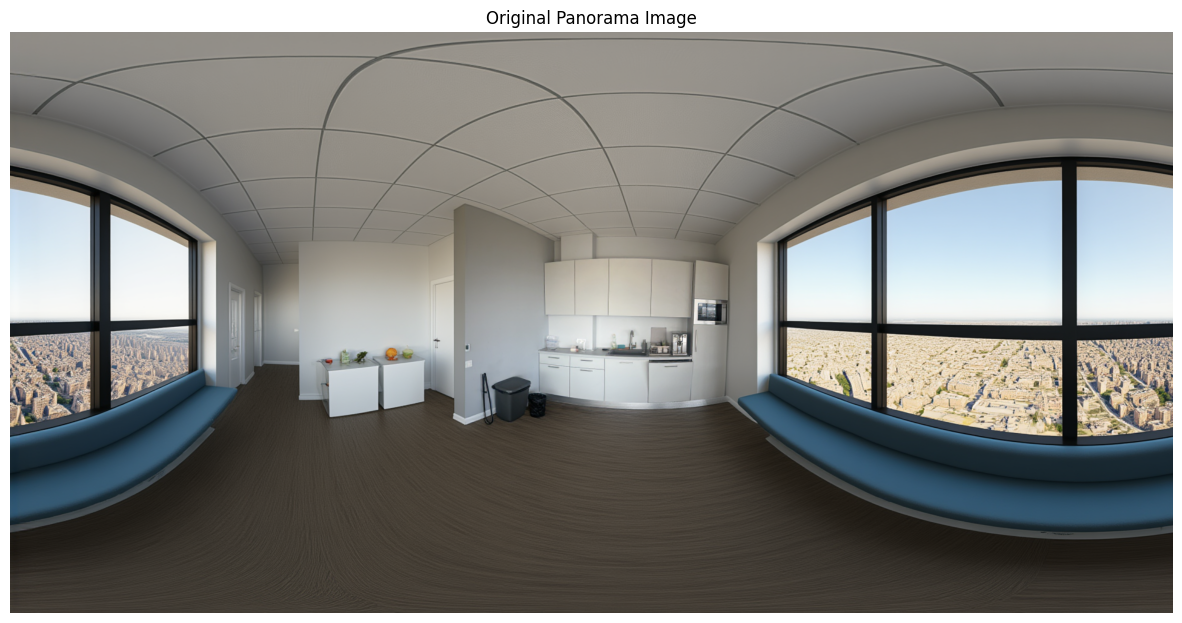

Original panorama size: (1920, 960)


In [12]:
# Optional: Load and display the original panorama for comparison
panorama_path = os.path.join(mesh_dir, "panorama.png")

if os.path.exists(panorama_path):
    print("Loading original panorama for comparison...")
    panorama = Image.open(panorama_path)
    
    plt.figure(figsize=(15, 8))
    plt.imshow(panorama)
    plt.title("Original Panorama Image")
    plt.axis('off')
    plt.show()
    
    print(f"Original panorama size: {panorama.size}")
else:
    print("Original panorama not found")


In [19]:
# Custom rendering function for specific viewpoints
def render_custom_view(meshes, eye_position, target_position, up_vector=[0, 0, 1], 
                       width=1024, height=768, background_color=[1, 1, 1]):
    """
    Render a custom view with manually specified camera parameters
    
    Args:
        meshes: List of Open3D triangle meshes
        eye_position: Camera position [x, y, z]
        target_position: Point the camera is looking at [x, y, z]
        up_vector: Camera up vector [x, y, z]
        width, height: Image dimensions
        background_color: RGB background color [r, g, b]
    
    Returns:
        numpy array: Rendered image
    """
    camera_config = {
        'position': eye_position,
        'target': target_position,
        'up': up_vector
    }
    
    return render_view(meshes, camera_config, width, height, background_color)

# Example: Render a custom view
if len(meshes) > 0:
    print("Example: Rendering a custom view...")
    
    # Define a custom camera position
    custom_eye = overall_center + np.array([5, 5, 3])  # Position camera at an angle
    custom_target = overall_center  # Look at the scene center
    
    custom_image = render_custom_view(meshes, custom_eye, custom_target)
    
    # Display the custom view
    plt.figure(figsize=(10, 8))
    plt.imshow(custom_image)
    plt.title("Custom Camera View")
    plt.axis('off')
    plt.show()
    
    # Save the custom view
    custom_output_path = os.path.join(output_dir, "custom_view.png")
    custom_image_pil = Image.fromarray((custom_image * 255).astype(np.uint8))
    custom_image_pil.save(custom_output_path)
    print(f"Custom view saved to: {custom_output_path}")

print("\n🎉 Rendering complete! Check the output directory for all rendered views.")


Example: Rendering a custom view...
[Open3D WARNING] GLFW Error: OSMesa: Library not found
[Open3D WARNING] Failed to create window


AttributeError: 'open3d.cuda.pybind.geometry.TriangleMesh' object has no attribute 'copy'